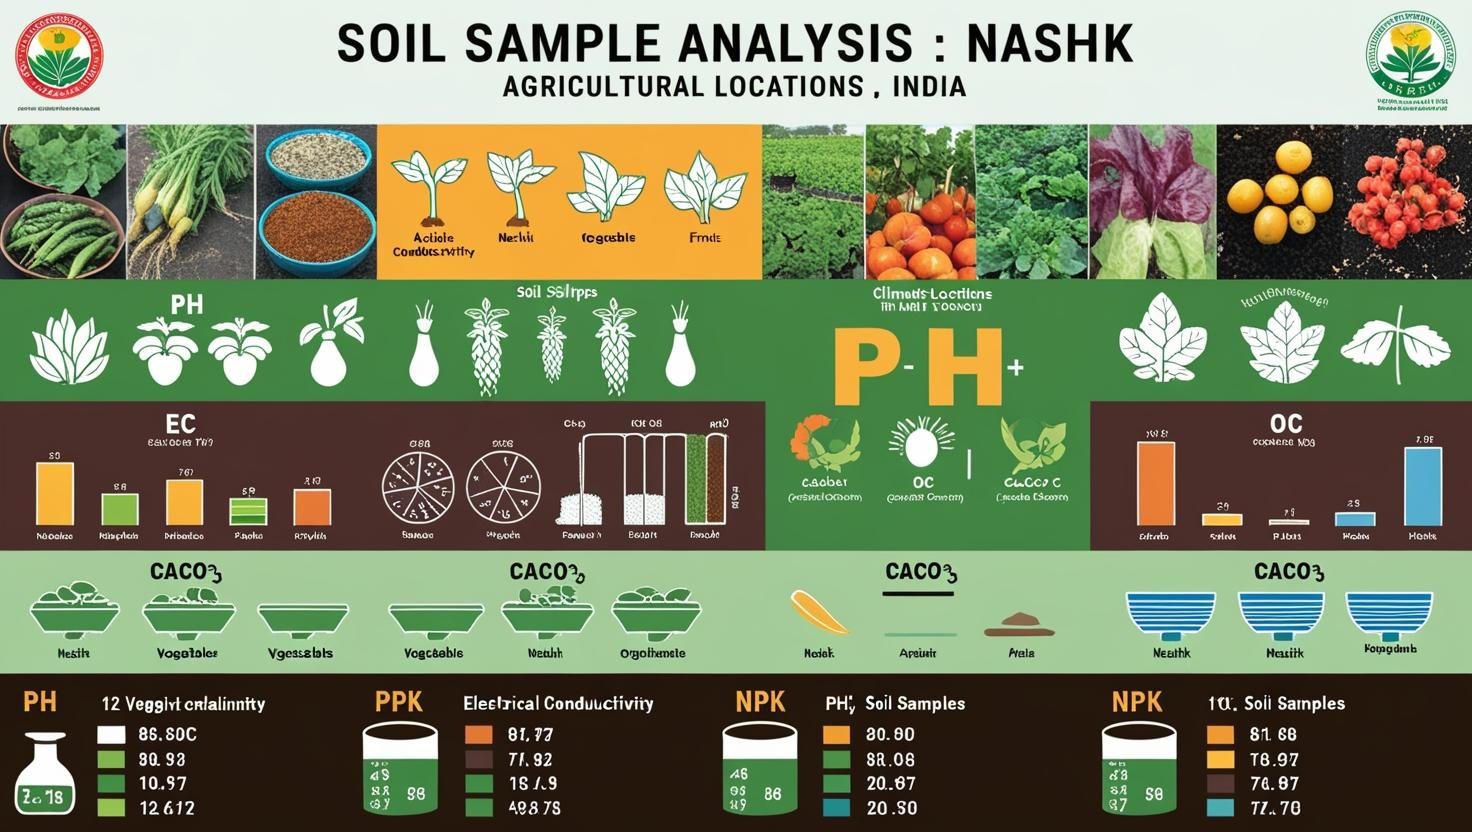

This dataset consists of soil sample analysis from multiple agricultural locations in Nashik, capturing various soil types and climatic conditions.

The dataset includes crucial soil properties such as: 
* **pH:** Acidity/alkalinity of the soil. 
* **EC (Electrical Conductivity):** A measure of the soil's ability to conduct electricity, indicating salinity levels. 
* **CaCO₃:** Calcium carbonate content, reflecting the alkalinity of the soil. 
* **OC (Organic Carbon):** Organic matter content in the soil. 
* **N,P,K levels:** Nitrogen, Phosphorus, Potassium. Key nutrients for plant growth. 
* **Label:** Type of crop (vegetable/fruit)

These features are measured for 14 crops (12 vegetables and 2 fruits) to help analyze soil health and **predict most probable, suitable crops for given soil conditions**.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import matplotlib.pyplot as plt
from keras.layers import Dense,Softmax
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-predication-dataset-based-on-nashik-region/Crop_Predication_dataset.xlsx


In [2]:
df=pd.read_excel("/kaggle/input/crop-predication-dataset-based-on-nashik-region/Crop_Predication_dataset.xlsx")

In [3]:
df.head(4)

,ph,EC,CaCO3,OC,N,P,K,label
0,5.6,0.330,6.0,0.16,125.0,37.0,200.0,bajra
1,7.5,0.820,7.0,0.15,132.0,35.0,169.0,bajra
2,5.6,0.212,3.0,0.19,145.0,38.0,122.0,bajra
3,6.9,0.469,9.0,0.14,124.0,38.0,134.0,bajra


To **normalize the pH** values in the dataset by scaling down any values greater than 100 (dividing them by 100), ensuring accurate representation and consistency for soil health analysis and crop prediction.

In [4]:
df['ph']=np.where(df['ph']>100,df['ph']/100,df['ph'])

Now, we will group the dataset by the **label** column and calculate the **mean** of all numeric columns for each group. Then, by applying a background color gradient, we will visually highlight the variations in the **mean** values across different labels.

In [5]:
gr=df.groupby(by="label").mean(numeric_only=True)
gr.style.background_gradient(cmap="coolwarm")

,ph,EC,CaCO3,OC,N,P,K
label,,,,,,,
bajra,6.521782,0.411198,6.544554,0.169901,173.702970,34.920792,172.574257
cabbage,6.490099,0.581347,5.925941,0.244455,50.247525,49.841584,70.475248
cauliflower,7.163333,0.576833,5.820000,0.246667,160.000000,8.030000,291.781667
cotton,6.963162,0.240833,6.511905,4.875952,184.891786,14.643095,390.981548
grapes,6.719808,0.592552,5.730690,0.510672,202.241638,11.989147,351.307759
jowar,6.728039,0.415206,6.568627,0.169706,182.588235,8.938922,425.647157
maize,6.296426,0.260000,5.683960,0.332578,156.972277,24.068317,149.652475
onion,7.397353,0.584559,5.565294,0.223529,163.407647,7.262588,341.084941
pomegranate,6.429172,0.324500,5.665800,0.763400,18.870000,18.750000,40.210000


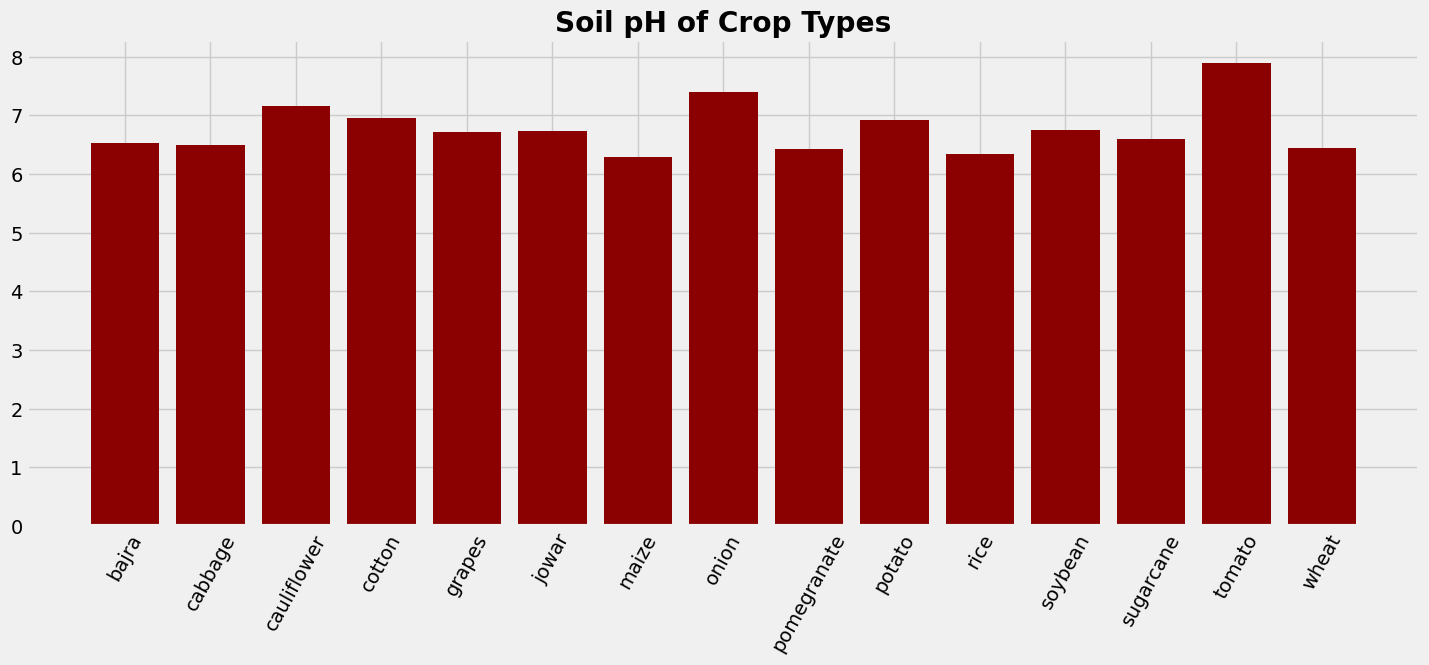

In [6]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(16,6))
plt.bar(gr.index, gr['ph'], color='#8B0000')
plt.xticks(rotation=61)
plt.title("Soil pH of Crop Types", fontweight="bold")
plt.show()

We will use **Label Encoding** to **convert categorical crop types** in the 'label' column **into numerical values**, making the dataset suitable **for machine learning models that require numerical input**. This transformation allows models to efficiently process and differentiate between different crop types. By encoding crop labels into unique integers, we ensure consistency in data representation and **enable better performance in classification and prediction** tasks.

In [7]:
le=LabelEncoder()
ley=le.fit_transform(df['label'])

In [8]:
ley.shape

(1239,)

We will apply **to_categorical(ley)** to convert the numerical labels (encoded by LabelEncoder) into a one-hot encoded format, which is essential for classification tasks in machine learning. **One-hot encoding prevents the model from assuming any ordinal relationship between crop types**. This transformation ensures that each crop type is represented as a binary vector, making classification more accurate. Each row is a one-hot encoded representation of the corresponding crop type. This ensures that **all crop types are treated equally without implying any ranking**.

In [9]:
y=to_categorical(ley)

In [10]:
y[555]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
df.iloc[555]

ph       6.801639
EC           0.26
CaCO3         4.7
OC           0.42
N           150.6
P            20.4
K           138.5
label       maize
Name: 555, dtype: object

In [12]:
df.head(4)

,ph,EC,CaCO3,OC,N,P,K,label
0,5.6,0.330,6.0,0.16,125.0,37.0,200.0,bajra
1,7.5,0.820,7.0,0.15,132.0,35.0,169.0,bajra
2,5.6,0.212,3.0,0.19,145.0,38.0,122.0,bajra
3,6.9,0.469,9.0,0.14,124.0,38.0,134.0,bajra


**Why Standardization?**
* Ensures all features are on the **same scale**, preventing models from being biased toward features with larger values.
* Helps **gradient-based optimization** (e.g., neural networks, logistic regression) converge faster.
* **Improves model performance and stability**, especially for algorithms sensitive to feature scaling.

Now, we will apply standardization to our dataset.

In [13]:
x=df.drop('label',axis=1)
ss=StandardScaler()
x=ss.fit_transform(x)

In [14]:
x.shape

(1239, 7)

We will divide the dataset into **training and test sets**, ensuring a reliable evaluation process for machine learning models in soil analysis and crop prediction. **80% of the data is used for training, while 20% is reserved for testing.**

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=53)

We will use deep learning model using **Keras' Sequential API** for crop prediction based on soil properties.

**What This Model Does:**
* Takes 7 soil properties as input.
* Passes data through hidden layers that learn relationships between soil characteristics and crops.
* Outputs a probability distribution over 15 possible crop types using softmax activation.
* The predicted crop type is the one with the highest probability.

In [16]:
model=Sequential() #layers are added one after another in a linear fashion

model.add(Dense(64,activation="relu",input_shape=(7,))) #input has 7 features, corresponding to the soil properties
model.add(Dense(32,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(32,activation="relu"))

model.add(Dense(15,activation="softmax"))
#The output layer has 15 neurons, corresponding to 15 crop types
#The softmax activation function is used to output probabilities for each crop type

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


* Adds four hidden layers, each with 32 neurons and ReLU activation.
* These layers allow the model to extract patterns and relationships between soil properties and crop types.
* More layers and neurons increase model capacity, allowing it to learn more complex interactions.

The four hidden layers with 32 neurons each help the model capture complex soil-crop relationships, improving crop prediction accuracy. The number of layers was chosen based on experimentation and tuning for the best performance. 🚀

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

Adam (Adaptive Moment Estimation) is used as the optimization algorithm.
It adjusts the learning rate dynamically based on past gradients, making training more stable and faster.

**Why Adam?**

❓Combines benefits of SGD & RMSProp → Fast convergence + Adaptive learning rate.

❓Works well with deep networks → Suitable for this model with multiple hidden layers.

❓Less sensitive to hyperparameters → Reduces the need for extensive tuning.

**Learning Rate (0.001):** Controls how much weights are updated during training. A small learning rate (0.001) ensures smooth and stable convergence, preventing overshooting.

The **loss** function measures how well the model's predictions match the true crop labels.
**Categorical** crossentropy is used because:

* This is a multi-class classification problem (15 crop types).
* The output layer has softmax activation, which provides probabilities for each class.
* Categorical crossentropy penalizes incorrect predictions more heavily, encouraging better learning.

**Accuracy** measures how often the model correctly predicts the crop type. It is a simple and intuitive metric, especially for balanced datasets like this one. During training, the model will try to **minimize loss and maximize accuracy**.

In [18]:
model.fit(x_train,y_train,epochs=120,batch_size=32,validation_split=0.2)
#epoch=120
#The model will go through the dataset 120 times to improve its accuracy.
#More epochs allow better learning, but too many can lead to overfitting.

#batch size = 32
#Helps in faster and more stable training than processing one sample at a time.
#Uses less memory than processing all data at once.
#A batch size of 32 is a commonly used default for good performance.

Epoch 1/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0753 - loss: 2.6938 - val_accuracy: 0.2714 - val_loss: 2.5536
Epoch 2/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3132 - loss: 2.4937 - val_accuracy: 0.3819 - val_loss: 2.1164
Epoch 3/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3503 - loss: 2.0139 - val_accuracy: 0.5126 - val_loss: 1.4967
Epoch 4/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5634 - loss: 1.4100 - val_accuracy: 0.7688 - val_loss: 0.9912
Epoch 5/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7357 - loss: 0.9474 - val_accuracy: 0.7437 - val_loss: 0.7271
Epoch 6/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7505 - loss: 0.7736 - val_accuracy: 0.7940 - val_loss: 0.6132
Epoch 7/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7525 - loss: 0.6792 - val_accuracy: 0.8291 - val_loss: 0.5419
Epoch 8/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8263 - loss: 0.5240 - val_accuracy: 0.8090 - 

In [19]:
model.evaluate(x_test,y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.7857 


[0.7599457502365112, 0.8548387289047241]

Mean Absolute Error (MAE): 0.1600
Mean Squared Error (MSE): 0.0280
Root Mean Squared Error (RMSE): 0.1673
R-Squared (R²): 0.9837


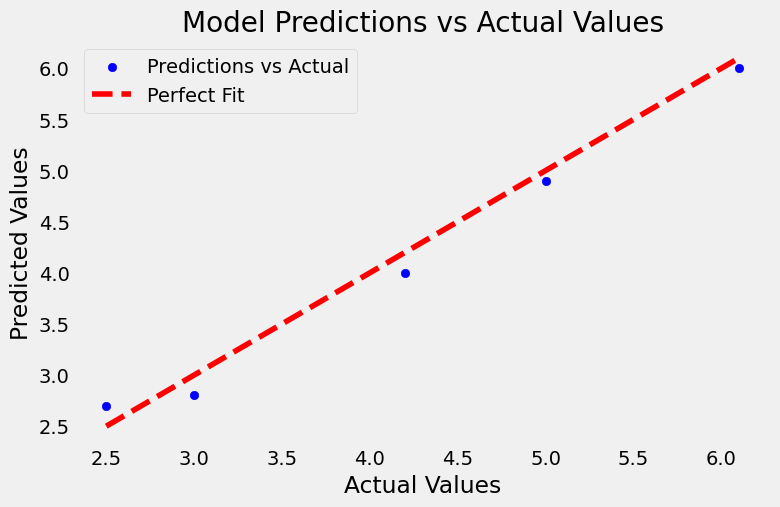

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Sample Data: Replace with actual values
y_test = np.array([3.0, 5.0, 2.5, 4.2, 6.1])  # Actual values
y_pred = np.array([2.8, 4.9, 2.7, 4.0, 6.0])  # Model predictions

# Calculate Error Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display Results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-Squared (R²): {r2:.4f}")

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue', label='Predictions vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Fit')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs Actual Values")
plt.legend()
plt.grid()
plt.show()
